<a href="https://colab.research.google.com/github/shivam0070/NYc-taxi-project-ml/blob/main/Copy_of_Copy_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

In [6]:
!pip install haversian

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement haversian (from versions: none)
ERROR: No matching distribution found for haversian


In [7]:
import numpy as np
import pandas as pd
import math
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import datetime , timedelta
from math import radians, cos, sin, asin, sqrt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn.metrics.pairwise import haversine_distances
import statsmodels.formula.api as sm
from sklearn.feature_selection import RFE
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Importing the dataset
df = pd.read_csv('/content/drive/MyDrive/NYC Taxi Data.csv')

# Data Exploration 

We will explore the data and modify dataset as per the our requirment for the further analysis of the problem.

In [9]:
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [10]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [11]:
#Check shape of dataset
df.shape

(1458644, 11)

There are approx 1.5 million records in our dataset.

# Checking for NaN and null data

In [12]:

df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There is no NaN/NULL record in the dataset, So we dont have to impute any record.

# Converting pickup and dropoff time to DateTime format.

In [13]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# New Features Creating

In [14]:
df['pickup_weekday']=df['pickup_datetime'].dt.day_name()
df['dropoff_weekday']=df['dropoff_datetime'].dt.day_name()
df['pickup_weekday_num']=df['pickup_datetime'].dt.weekday
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['month']=df['pickup_datetime'].dt.month

 

* pickup_weekday: This will contain the day on which ride was taken.

*    dropoff_weekday: This will contain the day on which ride was ended.

*   pickup_hour: time at which ride was started.

*  dropoff_hour: time at which ride was stoped.
*  pickup_weekday_num: number of the day on which ride was taken, taking Monday as 0.



In [15]:
df.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_weekday  \
0         40.765602                  N            455         Monday   
1         40.731152                  N            663         Sunday   
2         40.710087                  N           2124        Tuesday   
3         40.706718                  N            429      Wednesday   
4         40.782520                  N            435       Saturday   

  dropoff_weekday  pickup_weekday_num  pickup_hour  dropoff_hour  month  
0          Monday                   0           17            17      3  
1          Sunday                   6            0             0      6  
2         Tuesday                   1           11            12      1  
3       Wednesday                   2           19            19      4  
4        Saturday                   5           13            13      3

In [16]:
# Calculate distance from given latitude and longitude
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])

In [17]:
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)

In [18]:
df['speed'] = (df.distance/(df.trip_duration/3600))

# Univariate Analysis

**Number of passengers per Cab**

This is done to check what are the what are the minimum and maximum number of passengers travel per taxi, and to check whether there are any outliers in our dataset.


In [19]:
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

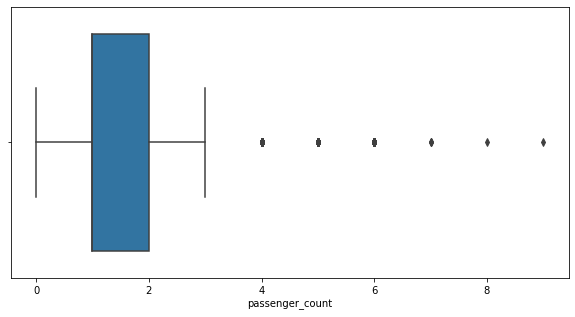

In [20]:
# Ploting passenger count using sns box plot.
plt.figure(figsize = (10,5))
sns.boxplot(df.passenger_count)
plt.show()



*  From the above Box Plot we can clearly notice there are some outliers in our dataset. It shows number of passengers per taxi is more than 7.

* In most of the trips passenger number is between 1 or 2. 
*  Minimum number of passengers per taxi is 0. 





In [21]:
#checking the overall statistics of the passenger count using .describe()
df.passenger_count.describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

As per above details. Mean median and mode are all approx equal to 1. So we would replace the 0 passenger count with 1.
So, we can replace 0 with 1 in passenger count data. Also we will remove the outliers in data which says passenger count is 7 or greater than 7, because it seems impossible to fit 7 passengers in a Taxi.



In [22]:
df['passenger_count'] = df.passenger_count.map(lambda x: 1 if x == 0 else x)
df = df[df.passenger_count <= 6]
df.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

Now the data is consistent with respect to the passenger count. Let's take a look at the ditribution with a graph below

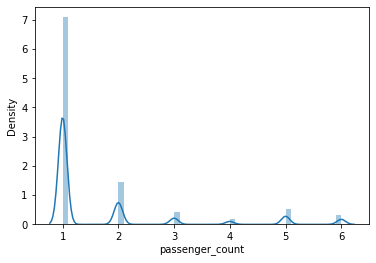

In [23]:
sns.distplot(df.passenger_count)
plt.show()

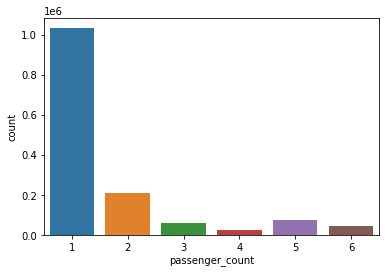

In [24]:
sns.countplot(df.passenger_count)
plt.show()

It is evident that most of the trips was taken by single passenger and that is inline with our day to day observations

# Trip Duration

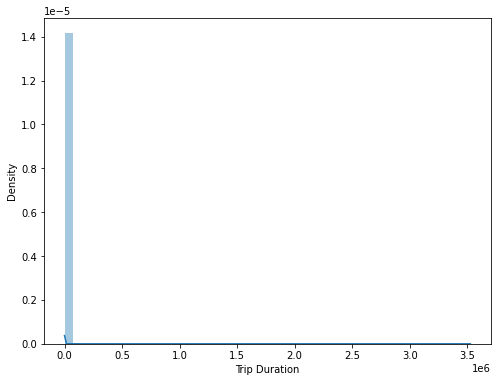

In [25]:
plt.figure(figsize = (8,6))
sns.distplot(df['trip_duration'])
plt.xlabel('Trip Duration')
plt.show()

From above graph we can see that it is Right skewed, lets apply log transformation to normalize it

TypeError: ignored

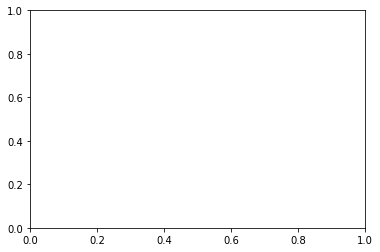

In [29]:
plt.hist(df['distance'].values,bins=300)
plt.xlabel('trip distance(km)')
plt.ylabel('number of records')

plt.show()

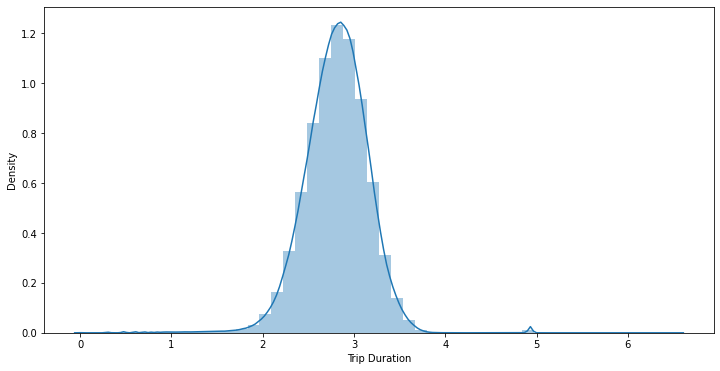

In [30]:
plt.figure(figsize = (12,6))
sns.distplot(np.log10(df['trip_duration']))
plt.xlabel('Trip Duration')
plt.show()

We can spot an outlier near 5 in the above plot.

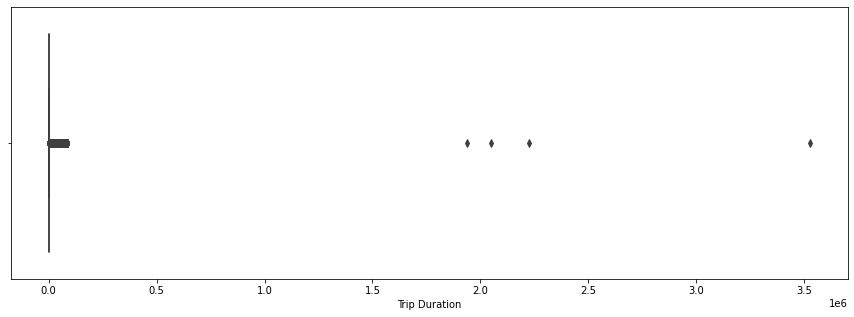

In [31]:
plt.figure(figsize = (15,5))
sns.boxplot(df.trip_duration)
plt.xlabel('Trip Duration')
plt.show()

**Number of Trips Taken per Minute**

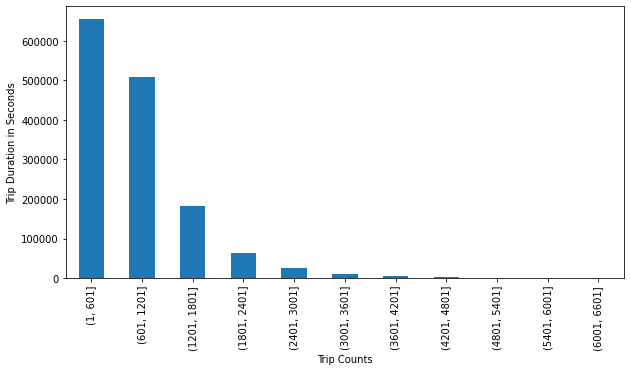

In [28]:
plt.figure(figsize = (10,5))
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration in Seconds')
plt.show()

Most of the trips took around 1800 seconds.

In [32]:
print( df['trip_duration'].nlargest(10))
print( df['trip_duration'].nsmallest(10))

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64
35196     1
207497    1
269418    1
279493    1
285635    1
311745    1
346102    1
346959    1
404610    1
451396    1
Name: trip_duration, dtype: int64


**Box Plot showing Trip Duration and the Outliers**

In [33]:
df = df[df.trip_duration <= 5000]
df = df[df.trip_duration >= 30]

In [27]:
fig = px.box(df, x='trip_duration', points='outliers')
fig.show()

In above Box Plot Q1 is 399, median is 663 and Q3 is 1073. From this we can deduce that most of the trips took 11-18 minutes to complete.

In [34]:
# Converting pickup and dropoff time to DateTime format.
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Total Trips per Hour

ValueError: ignored

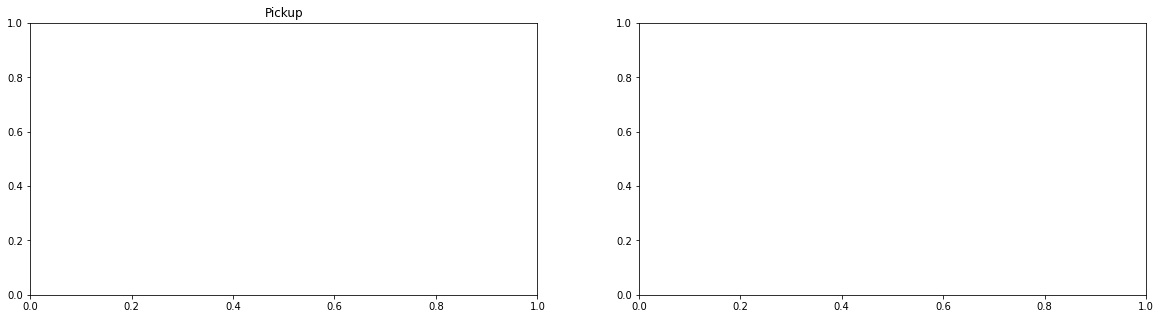

In [36]:
# Ploting pickup and dropoff hour vs number of rides graph
figure,(fig1,fig2)=plt.subplots(ncols=2,figsize=(20,5))
fig1.set_title('Pickup')
ax=sns.countplot(x="pickup_hours",df=df,ax=fig1)
fig2.set_title('Dropoff')
ax=sns.countplot(x="dropoff_hour",df=df,ax=fig2)

# Trip Duration per Weekday

In [37]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_weekday',y='trip_duration',df=df)
plt.ylabel('Duration in seconds')
plt.xlabel('weekday')
plt.show()

ValueError: ignored

<Figure size 720x360 with 0 Axes>

# Trips Per Day

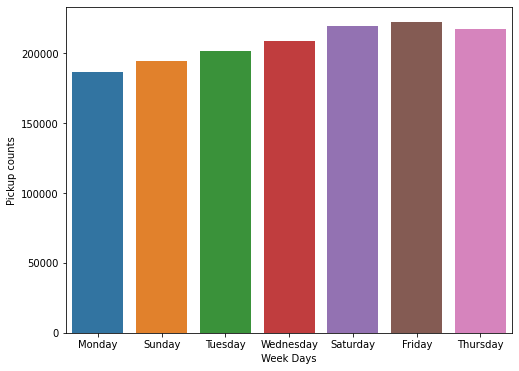

In [38]:
plt.figure(figsize = (8,6))
sns.countplot(df.pickup_weekday)
plt.xlabel(' Week Days ')
plt.ylabel('Pickup counts')
plt.show()



*   We can see the number of pickups starts increasing from monday to friday, then starts decreasing on weekends. Because offices and other establishments are closed on weekends. 
*   Pickups are maximum on friday most probably because of the weekend. 



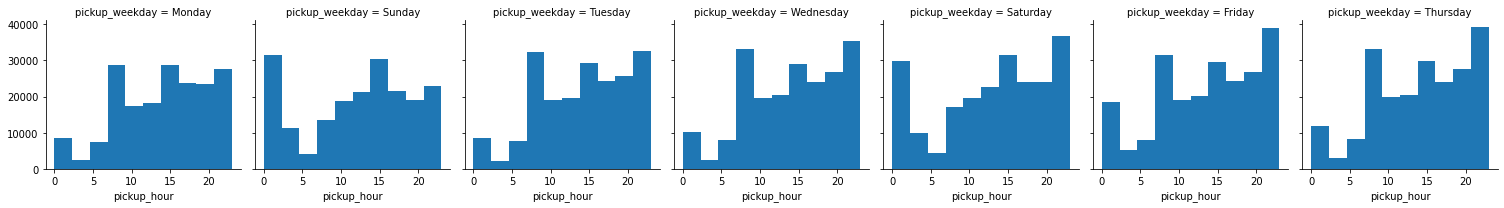

In [39]:
n = sns.FacetGrid(df, col='pickup_weekday')
n.map(plt.hist, 'pickup_hour')
plt.show()



*  During weekends late night pickups are more than weekdays.
*   There is consistent high pickups at 7 AM during weekdays, most probably beacause of office hours.



# Bivariate Analysis

We will use groupby function to combine pickup hour and trip duration and ll use mean aggregate function. Then we are going to plot the graph to see at which hour of the day trip duration is maximum.

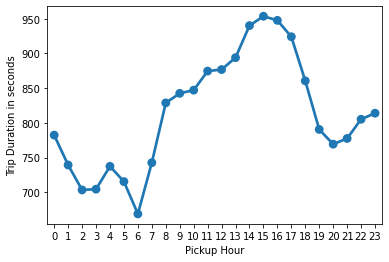

In [40]:
# Using group by function on time of pickup and trip duration mean
duration = df.groupby('pickup_hour').trip_duration.mean()

# Ploting graph of above dataset
sns.pointplot(duration.index, duration.values)
plt.ylabel('Trip Duration in seconds')
plt.xlabel('Pickup Hour')
plt.show()



*    From above plot we can see lowest mean trip duration is at 6 AM.
*  Highest mean trip duration is at 3 PM. Most probaly due to high traffic, as its closing hour for offices and schools.  



**Trip Duration per Weekday**

In [41]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_weekday',y='trip_duration',df=df)
plt.ylabel('Duration in seconds')
plt.xlabel('weekday')
plt.show()

ValueError: ignored

<Figure size 720x360 with 0 Axes>

**Trip Duration per Month**

In [44]:
plt.figure(figsize = (10,5))
sns.lineplot(x='month',y='trip_duration', df=df)
plt.ylabel('Duration in seconds')
plt.xlabel('Month of Trip ')
plt.show()

ValueError: ignored

<Figure size 720x360 with 0 Axes>

In [43]:
plt.figure(figsize = (10,5))
sns.lineplot(x='month',y='trip_duration', df=df)
plt.ylabel('Duration in seconds')
plt.xlabel('Month of Trip ')
plt.show()

ValueError: ignored

<Figure size 720x360 with 0 Axes>

**Trip Duration per Vendor**

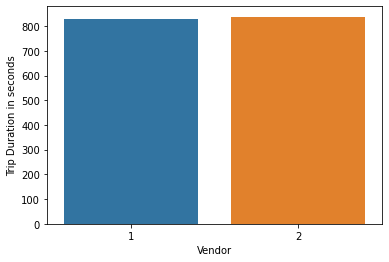

In [45]:
df1 = df.groupby('vendor_id').trip_duration.mean()
sns.barplot(df1.index, df1.values)
plt.ylabel('Trip Duration in seconds')
plt.xlabel('Vendor')
plt.show()

Here we analyze taxi data only for the 2 vendors which are listed as 1 and 2 in the datset.

Though both the vendors seems to have almost equal market share. But Vendor 2 is evidently more famous among the population as per the above graph.

**Trip Distance and Duration Distribution**

In [46]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_weekday', 'dropoff_weekday',
       'pickup_weekday_num', 'pickup_hour', 'dropoff_hour', 'month',
       'distance', 'speed'],
      dtype='object')

TypeError: ignored

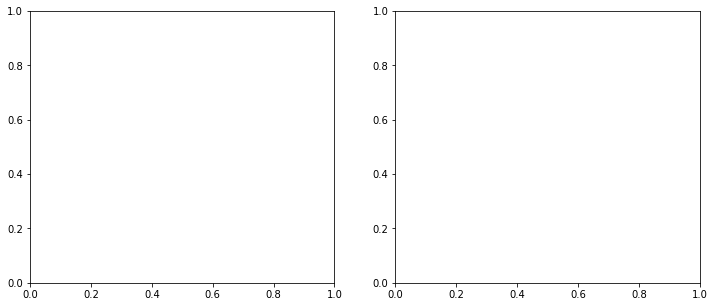

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].hist(df['distance'].values, bins=300)
ax[0].set_xlabel('trip distance(km)')
ax[0].set_ylabel('number of records')

ax[1].hist(df['trip_duration'].values, bins=60)
ax[1].set_xlabel('trip duration in sec')
ax[1].set_ylabel('number of records')

plt.show()

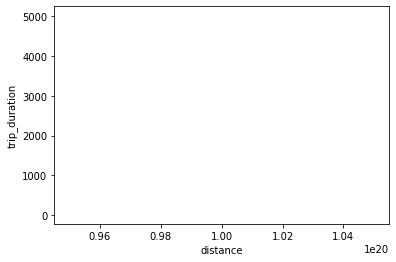

In [48]:
df.plot(x='distance',y='trip_duration',kind='scatter') 
plt.show()

In [49]:
dummy = pd.get_dummies(df.store_and_fwd_flag, prefix='flag', drop_first=True)
df= pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.pickup_weekday, prefix='pickup_weekday', drop_first=True)
df = pd.concat([df,dummy], axis = 1)

In [50]:
df['trip_duration_hour']=df['trip_duration']/3600

In [51]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_weekday', 'dropoff_weekday',
       'pickup_weekday_num', 'pickup_hour', 'dropoff_hour', 'month',
       'distance', 'speed', 'flag_Y', 'pickup_weekday_Monday',
       'pickup_weekday_Saturday', 'pickup_weekday_Sunday',
       'pickup_weekday_Thursday', 'pickup_weekday_Tuesday',
       'pickup_weekday_Wednesday', 'trip_duration_hour'],
      dtype='object')

**Location Visualization On Map**

Plotting pickup and dropoff location according to their lattitude and longitude. Here we can see the map of the streets of NYC very clearly.

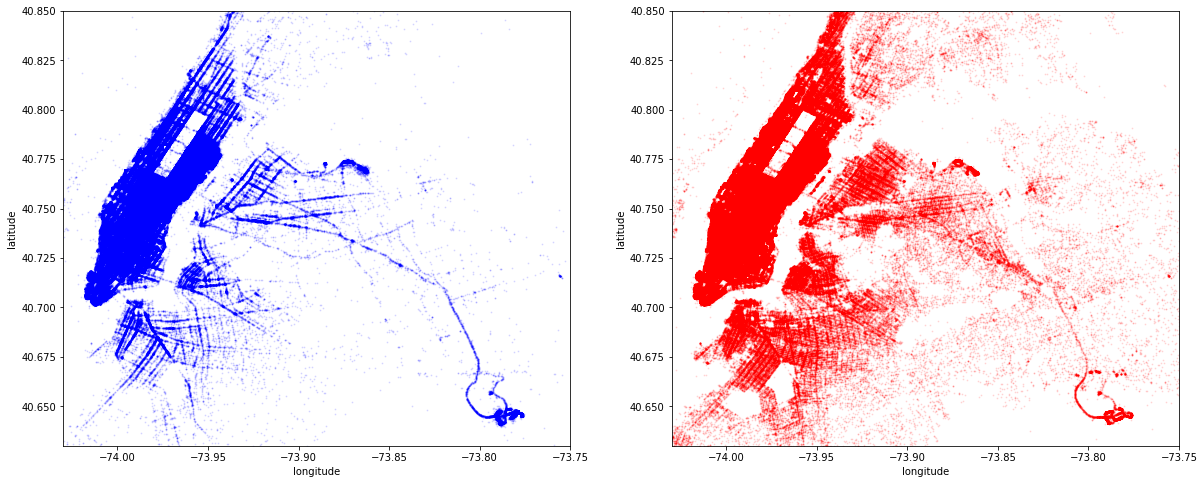

In [52]:
plt.figure(figsize=(20,8))
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.subplot(121)
plt.scatter(df['pickup_longitude'].values, df['pickup_latitude'].values,
              color='blue', s=1, alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.subplot(122)
plt.scatter(df['dropoff_longitude'].values, df['dropoff_latitude'].values,
              color='red', s=1, alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [53]:
df.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  distance speed flag_Y  \
0         40.765602                  N  ...      None   NaN      0   
1         40.731152                  N  ...      None   NaN      0   
2         40.710087                  N  ...      None   NaN      0   
3         40.706718                  N  ...      None   NaN      0   
4         40.782520                  N  ...      None   NaN      0   

   pickup_weekday_Monday  pickup_weekday_Saturday  pickup_weekday_Sunday  \
0                      1                        0                      0   
1                      0                        0                      1   
2                      0                        0                      0   
3                      0                        0                      0   
4                      0                        1                      0   

   pickup_weekday_Thursday pickup_weekday_Tuesday pickup_weekday_Wednesday  \
0                        0                      0                        0   
1                        0                      0                        0   
2                        0                      1                        0   
3                        0                      0                        1   
4                        0                      0                        0   

   trip_duration_hour  
0            0.126389  
1            0.184167  
2            0.590000  
3            0.119167  
4            0.120833  

[5 rows x 27 columns]

In [54]:
df.shape

(1450087, 27)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450087 entries, 0 to 1458643
Data columns (total 27 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   id                        1450087 non-null  object        
 1   vendor_id                 1450087 non-null  int64         
 2   pickup_datetime           1450087 non-null  datetime64[ns]
 3   dropoff_datetime          1450087 non-null  datetime64[ns]
 4   passenger_count           1450087 non-null  int64         
 5   pickup_longitude          1450087 non-null  float64       
 6   pickup_latitude           1450087 non-null  float64       
 7   dropoff_longitude         1450087 non-null  float64       
 8   dropoff_latitude          1450087 non-null  float64       
 9   store_and_fwd_flag        1450087 non-null  object        
 10  trip_duration             1450087 non-null  int64         
 11  pickup_weekday            1450087 non-null  object

# Correlation Heatmap

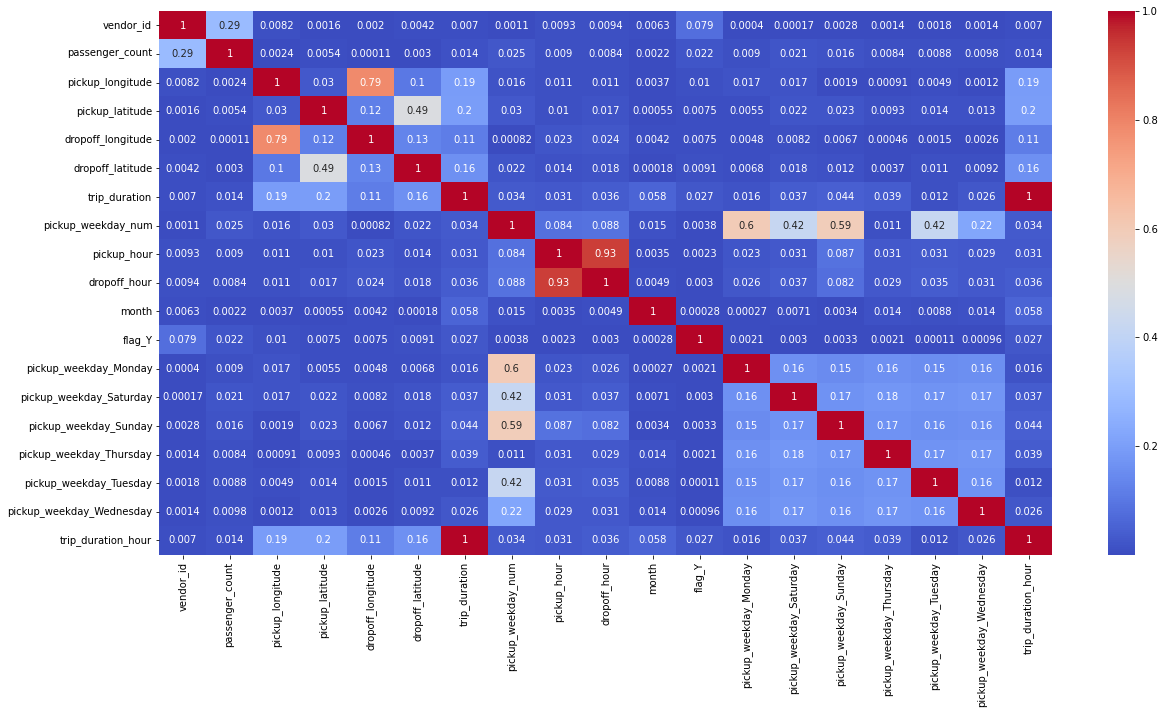

In [56]:
plt.figure (figsize= (20,10))
corelation= df.corr()
sns.heatmap(abs(corelation), annot=True, cmap='coolwarm')
plt.show()

**Observation** 


* From the above co-relation heatmap we can see that there isn't much relation between the variables except distance-trip duration and dropoff longitude and pickup longitude.
   
*  The relation between pickup and dropoff longitude might be due to the outliers, because it can't be same except the trip is a round trip. But we suspect there is surely not that much of trip which are round trip.  



In [57]:
df = df.drop(['flag_Y','vendor_id'], axis=1)
numeric_features= df.describe().columns
features= numeric_features.copy()
features= list(features)
features= features[:-1]
features

['passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'pickup_weekday_num',
 'pickup_hour',
 'dropoff_hour',
 'month',
 'pickup_weekday_Monday',
 'pickup_weekday_Saturday',
 'pickup_weekday_Sunday',
 'pickup_weekday_Thursday',
 'pickup_weekday_Tuesday',
 'pickup_weekday_Wednesday']

In [58]:
len(features)

16

# Model Selection

In [59]:
X = df[features].apply(zscore)[:] 
X

passenger_count  pickup_longitude  pickup_latitude  \
0              -0.505889         -0.119582         0.517811   
1              -0.505889         -0.094969        -0.381952   
2              -0.505889         -0.075322         0.395349   
3              -0.505889         -0.514137        -0.951490   
4              -0.505889          0.009202         1.291957   
...                  ...               ...              ...   
1458639         1.776387         -0.120229        -0.168813   
1458640        -0.505889         -0.385461        -0.111906   
1458641        -0.505889          0.206210         0.544219   
1458642        -0.505889         -0.118502        -0.060374   
1458643        -0.505889         -0.082555         0.940933   

         dropoff_longitude  dropoff_latitude  trip_duration  \
0                 0.127059          0.384543      -0.596266   
1                -0.367889         -0.581295      -0.268840   
2                -0.450994         -1.171856       2.031012   
3                -0.549486         -1.266290      -0.637194   
4                 0.009281          0.858853      -0.627749   
...                    ...               ...            ...   
1458639          -0.302987         -0.328472      -0.087811   
1458640           0.048179          1.252096      -0.281433   
1458641          -0.438209         -1.248002      -0.109849   
1458642          -0.014989          0.146372      -0.725347   
1458643           0.010907          1.084938      -1.000826   

         pickup_weekday_num  pickup_hour  dropoff_hour     month  \
0                 -1.560911     0.529716      0.524089 -0.306819   
1                  1.509507    -2.126402     -2.098026  1.477927   
2                 -1.049175    -0.407737     -0.247121 -1.496649   
3                 -0.537439     0.842201      0.832573  0.288096   
4                  0.997771    -0.095253     -0.092879 -0.306819   
...                     ...          ...           ...       ...   
1458639            0.486034    -0.095253     -0.092879  0.288096   
1458640            1.509507    -1.032706     -1.018332 -1.496649   
1458641            0.486034    -1.188948     -1.018332  0.288096   
1458642           -1.049175     0.217232      0.369847 -1.496649   
1458643           -1.049175     0.060989      0.061363  0.288096   

         pickup_weekday_Monday  pickup_weekday_Saturday  \
0                     2.604112                -0.422595   
1                    -0.384008                -0.422595   
2                    -0.384008                -0.422595   
3                    -0.384008                -0.422595   
4                    -0.384008                 2.366331   
...                        ...                      ...   
1458639              -0.384008                -0.422595   
1458640              -0.384008                -0.422595   
1458641              -0.384008                -0.422595   
1458642              -0.384008                -0.422595   
1458643              -0.384008                -0.422595   

         pickup_weekday_Sunday  pickup_weekday_Thursday  \
0                    -0.393185                -0.419693   
1                     2.543335                -0.419693   
2                    -0.393185                -0.419693   
3                    -0.393185                -0.419693   
4                    -0.393185                -0.419693   
...                        ...                      ...   
1458639              -0.393185                -0.419693   
1458640               2.543335                -0.419693   
1458641              -0.393185                -0.419693   
1458642              -0.393185                -0.419693   
1458643              -0.393185                -0.419693   

         pickup_weekday_Tuesday  pickup_weekday_Wednesday  
0                     -0.401844                 -0.410315  
1                     -0.401844                 -0.410315  
2                      2.488531                 -0.410315  
3                   

In [60]:
y= np.log10(df['trip_duration_hour'])[:]
y

0         -0.898291
1         -0.734789
2         -0.229148
3         -0.923845
4         -0.917813
             ...   
1458639   -0.665323
1458640   -0.740061
1458641   -0.673209
1458642   -0.984594
1458643   -1.259637
Name: trip_duration_hour, Length: 1450087, dtype: float64

**Splitting the Data into Train and  Test**


*Here we have splitted the dataset in 80:20 ratio. 80 is for training purpose and 20 is for testing the model.   
 



In [61]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, y_train.shape , X_test.shape, y_test.shape

((1160069, 16), (1160069,), (290018, 16), (290018,))

# Linear Regression

In [62]:
lr =  LinearRegression()
rfe = RFE(lr, n_features_to_select=12)
rfe= rfe.fit(X_train, y_train)
#printing the boolean result
rfe.support_

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False])

In [63]:
col= X_train.columns[rfe.support_]

In [64]:
X_train_rfe= X_train[col]

In [65]:
import statsmodels.api as sm
#Adding a constant variable
X_train_rfe= sm.add_constant(X_train_rfe)

In [66]:
lr= sm.OLS(y_train, X_train_rfe).fit()

In [67]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:     trip_duration_hour   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                 3.739e+05
Date:                Mon, 11 Jul 2022   Prob (F-statistic):               0.00
Time:                        06:41:26   Log-Likelihood:             5.9038e+05
No. Observations:             1160069   AIC:                        -1.181e+06
Df Residuals:                 1160056   BIC:                        -1.181e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [68]:
y_pred_train= lr.predict(X_train_rfe)

X_test_rfe= X_test[col]

X_test_rfe= sm.add_constant(X_test_rfe)

y_pred_test= lr.predict(X_test_rfe)

# Model Evaluation

In [69]:
# MSE RMSE R2 ADJUSTED R2 SCORE FOR TRAINING DATASET
lr_train_mse  = MSE((y_train), (y_pred_train))
print("Train MSE :" , lr_train_mse)

lr_train_rmse = np.sqrt(lr_train_mse)

print("Train RMSE :" ,lr_train_rmse)

lr_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,lr_train_r2) 

lr_train_r2_ = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lr_train_r2_)

Train MSE : 0.021158499880348545
Train RMSE : 0.14545961597759202
Train R2 : 0.7945782742723276
Train Adjusted R2 :  0.7945754409962231


In [70]:
# MSE RMSE R2 ADJUSTED R2 SCORE FOR TEST DATASET
lr_test_mse  = MSE((y_test), (y_pred_test))
print("Test MSE :" , lr_test_mse)

lr_test_rmse = np.sqrt(lr_test_mse)

print("Test RMSE :" ,lr_test_rmse)

lr_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lr_test_r2)

lr_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_r2_)

Test MSE : 0.021348393289939517
Test RMSE : 0.14611089380993983
Test R2 : 0.7916504483874633
Test Adjusted R2 :  0.7916389532794265


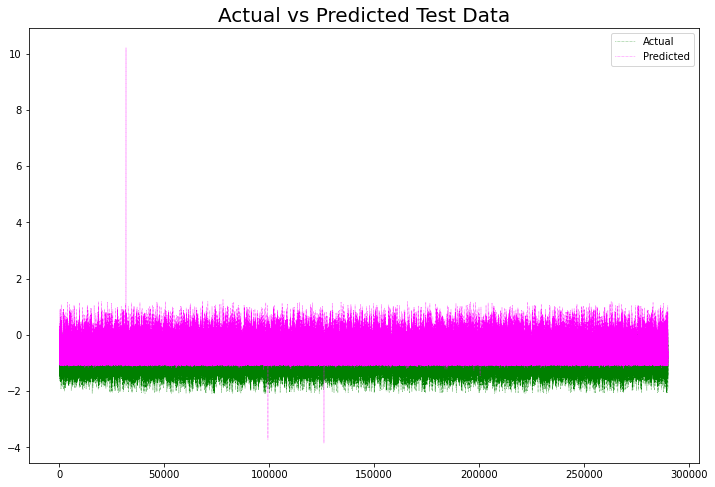

In [71]:
#Visualization of Actual vs Predicted Data
plt.figure(figsize= (12,8))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='green', linewidth=0.5, linestyle=':')
plt.plot(c, y_pred_test, color='magenta', linewidth=0.5, linestyle=':')
plt.title('Actual vs Predicted Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

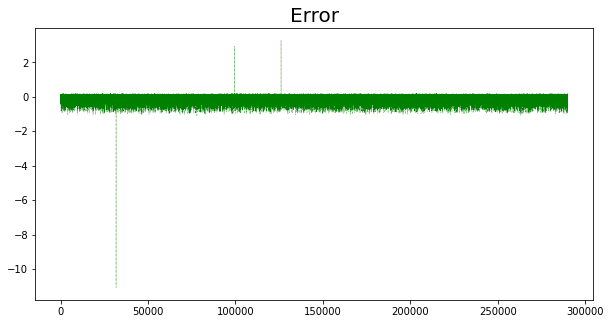

In [72]:
#Ploting the error
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_test, color='green', linewidth=0.5, linestyle=':')
plt.title('Error', fontsize=20)
plt.show()

# Lasso Regression

In [73]:
from sklearn.linear_model import Lasso

In [74]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV


In [75]:
# Defining the parameters for lasso regression
linear_model = Lasso()

params = {
    "alpha": np.arange(0.01,0.5,0.01)
}

search = RandomizedSearchCV(linear_model, param_distributions=params, random_state=0, n_iter=10, cv=3, verbose=1, 
                            n_jobs=-1, return_train_score=True)

search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
                   param_distributions={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49])},
                   random_state=0, return_train_score=True, verbose=1)

In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error as rmse

In [77]:
y_pred = search.predict(X_test)
y_test = y_test
r2_v2 = r2_score(y_test,y_pred)
mse_v2 = mean_squared_error(y_test, y_pred)
rmse_v2 = math.sqrt(mean_squared_error(y_test,y_pred))
# rmsle_v2 = rmse(y_test.values,y_pred)

pd.DataFrame({'R2':[r2_v2], 'MSE':[mse_v2], 'RMSE':[rmse_v2]})

R2       MSE     RMSE
0  0.766102  0.023966  0.15481

In [78]:
y_pred_lasso_train=search.predict(X_train)
y_pred_lasso_test=search.predict(X_test)

In [79]:
# MSE RMSE R2 ADJUSTED R2 SCORE FOR TRAINING DATASET
lasso_train_mse  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , lasso_train_mse)

lasso_train_rmse = np.sqrt(lasso_train_mse)
print("Train RMSE :" ,lasso_train_rmse)

lasso_train_r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,lasso_train_r2)

lasso_train_r2_= 1-(1-r2_score((y_train), (y_pred_lasso_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", lasso_train_r2_)

Train MSE : 0.024105296623581324
Train RMSE : 0.15525880530128178
Train R2 : 0.7659686811638019
Train Adjusted R2 :  0.7659654532903089


In [80]:
# MSE RMSE R2 ADJUSTED R2 SCORE FOR Test DATASET
lasso_test_mse  = mean_squared_error(y_test, y_pred_lasso_test)
print("Test MSE :" , lasso_test_mse)

lasso_test_rmse = np.sqrt(lasso_test_mse)
print("Test RMSE :" ,lasso_test_rmse)

lasso_test_r2 = r2_score(y_test, y_pred_lasso_test)
print("Test R2 :" ,lasso_test_r2)

lasso_test_r2_= 1-(1-r2_score((y_test), (y_pred_lasso_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", lasso_test_r2_)

Test MSE : 0.023966184984649388
Test RMSE : 0.1548101578858745
Test R2 : 0.7661021217101178
Test Adjusted R2 :  0.7660892170440903


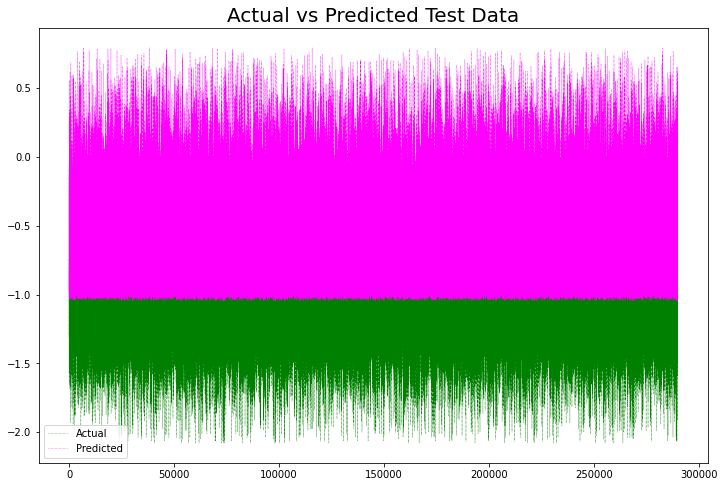

In [81]:
#Ploting the Actual vs Predicted data
plt.figure(figsize= (12,8))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='green', linewidth=0.5, linestyle=':')
plt.plot(c, y_pred_lasso_test, color='magenta', linewidth=0.5, linestyle=':')
plt.title('Actual vs Predicted Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

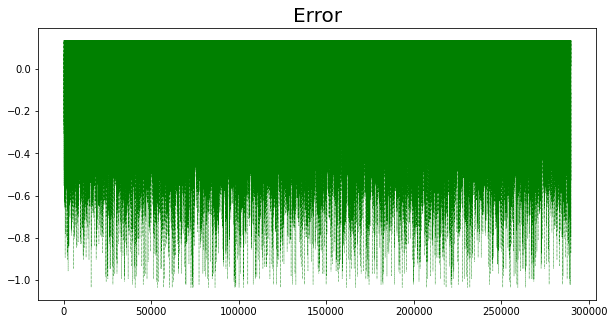

In [82]:
#Ploting the error
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_lasso_test, color='green', linewidth=0.5, linestyle=':')
plt.title('Error', fontsize=20)
plt.show()

# XGBoost Model

In [83]:
import xgboost as xgb

In [84]:
# Defining the parameters for smooth running of the xgboost
n_estimators = [80,150,200]
 
max_depth = [5,8,10]
min_samples_split = [40,50]
learning_rate=[0.2,0.4,0.6]
 
# Hyperparameter 
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_' : min_samples_split,
             'learning_rate' : learning_rate
             }

cache = {'n_estimators' : [200],
              'max_depth' : [8],
             'min_samples_' : [40],
             'learning_rate' : [0.2],
             }

In [86]:
xgb_model = xgb.XGBRegressor(tree_method = 'hist')

xgb_grid = GridSearchCV(estimator=xgb_model,
                        param_grid = cache,
                        cv = 3, verbose=1,
                        scoring="r2")

xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[06:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, estimator=XGBRegressor(tree_method='hist'),
             param_grid={'learning_rate': [0.2], 'max_depth': [8],
                         'min_samples_': [40], 'n_estimators': [200]},
             scoring='r2', verbose=1)

In [87]:
xgb_grid.best_score_

0.9993772959817967

In [88]:
xgb_grid.best_params_

{'learning_rate': 0.2, 'max_depth': 8, 'min_samples_': 40, 'n_estimators': 200}

In [89]:
y_pred_xgb_train=xgb_grid.predict(X_train)

In [90]:
y_pred_xgb_test=xgb_grid.predict(X_test)

In [91]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.6 MB/s 


In [92]:
# import shap
# explainer = shap.Explainer(xgb_grid, X_train)
# shap_values = explainer(X_train)
# shap.plots.beeswarm(shap_values)

In [93]:
# MSE RMSE R2 ADJUSTED R2 SCORE FOR TRAINING DATASET
xgb_train_mse  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , xgb_train_mse)

xgb_train_rmse = np.sqrt(xgb_train_mse)
print("Train RMSE :" ,xgb_train_rmse)

xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,xgb_train_r2)

xgb_train_r2_= 1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", xgb_train_r2_)

Train MSE : 1.536602883257483e-05
Train RMSE : 0.003919952656930289
Train R2 : 0.9998508156921229
Train Adjusted R2 :  0.9998508136345005


In [94]:
# MSE RMSE R2 ADJUSTED R2 SCORE FOR Test DATASET
xgb_test_mse  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , xgb_test_mse)

xgb_test_rmse = np.sqrt(xgb_test_mse)
print("Test RMSE :" ,xgb_test_rmse)

xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,xgb_test_r2)

xgb_test_r2_= 1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", xgb_test_r2_)

Test MSE : 6.260121469605335e-05
Test RMSE : 0.007912092940306842
Test R2 : 0.9993890437170057
Test Adjusted R2 :  0.999389010009189


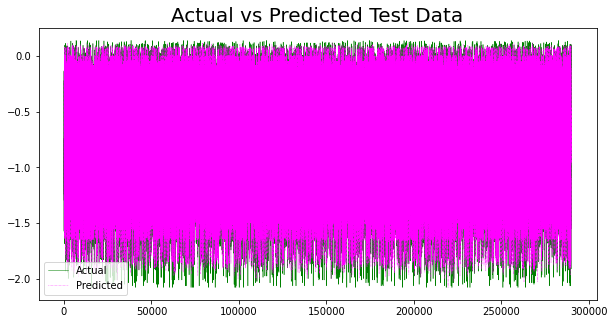

In [95]:
# Ploting graph for Actual vs Predicted data
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='green', linewidth=0.5, linestyle='-')
plt.plot(c, y_pred_xgb_test, color='magenta', linewidth=0.5, linestyle=':')
plt.title('Actual vs Predicted Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

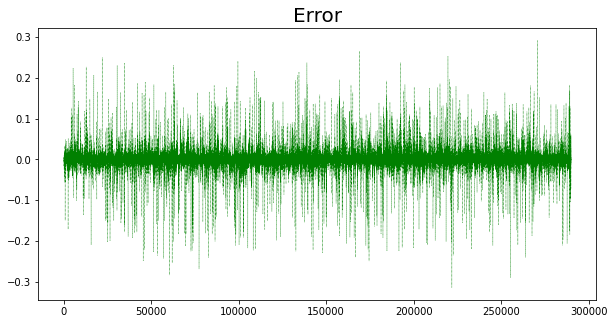

In [96]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_xgb_test, color='green', linewidth=0.5, linestyle=':')
plt.title('Error', fontsize=20)
plt.show()

**Feature Importance**

In [97]:
importance_df= pd.DataFrame({'Features': features, 'Feature_importance': list(xgb_grid.best_estimator_.feature_importances_)})
importance_df

Features  Feature_importance
0            passenger_count            0.000061
1           pickup_longitude            0.000099
2            pickup_latitude            0.000100
3          dropoff_longitude            0.000099
4           dropoff_latitude            0.000104
5              trip_duration            0.998861
6         pickup_weekday_num            0.000082
7                pickup_hour            0.000102
8               dropoff_hour            0.000047
9                      month            0.000087
10     pickup_weekday_Monday            0.000000
11   pickup_weekday_Saturday            0.000115
12     pickup_weekday_Sunday            0.000000
13   pickup_weekday_Thursday            0.000094
14    pickup_weekday_Tuesday            0.000052
15  pickup_weekday_Wednesday            0.000096

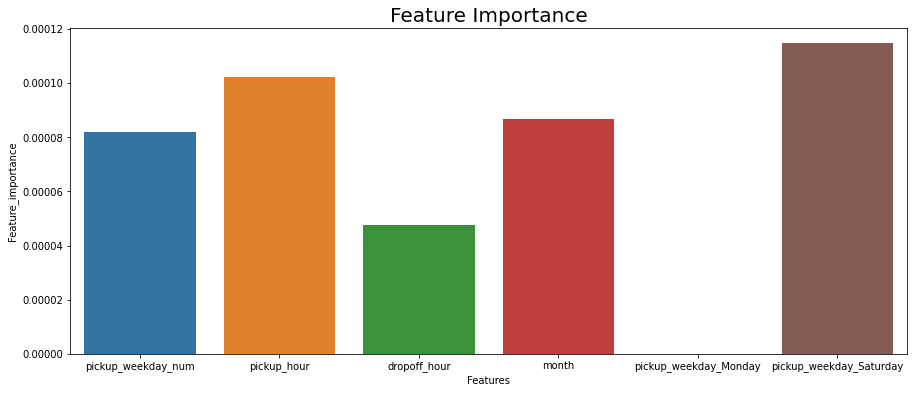

In [98]:
plt.figure(figsize=(15,6))
plt.title('Feature Importance', fontsize=20)
sns.barplot(x='Features',y="Feature_importance", data=importance_df[6:12])
plt.show()

**Observation** 

Among all variables Distance is the only parameter that affects the trip duration. Its obvious as we know ther is a linear relationship between distance and time taken to cover it

# LightGBM Model

In [99]:
#LightGBM 
import lightgbm as lgb

lgb_params = {
   'metric': 'rmse',
   'is_training_metric': True}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=100, valid_sets)

SyntaxError: ignored

In [100]:
#LightGBM with sklearn API 
from lightgbm import LGBMRegressor

lgbm = lgb.LGBMRegressor()
lgbm.fit(X, y)

print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test))
print('RMSE', np.sqrt(MSE(y_test, lgbm.predict(X_test))))

0.9994560902622642 0.9994511037702019
RMSE 0.007499484921894314


In [101]:
# adjusting parameters to get best result from the lightgbm regressor
from lightgbm import LGBMRegressor

lgbm = lgb.LGBMRegressor(n_estimators=500, num_leaves=1000, max_depth=25, objective='regression')
lgbm.fit(X, y)

print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test))
print('RMSE', np.sqrt(MSE(y_test, lgbm.predict(X_test))))

0.9999410561043993 0.9999388279500849
RMSE 0.0025035878170752957


In [102]:
y_pred_lgbm = lgbm.predict(X_train)
y_pred_lgbm_test = lgbm.predict(X_test)

In [103]:
# MSE RMSE R2 ADJUSTED R2 SCORE FOR TRAINING DATASET
lgbm_train_mse  = mean_squared_error(y_train, y_pred_lgbm)
print("Train MSE :" , lgbm_train_mse)

lgbm_train_rmse = np.sqrt(lgbm_train_mse)
print("Train RMSE :" ,lgbm_train_rmse)

lgbm_train_r2 = r2_score(y_train, y_pred_lgbm)
print("Train R2 :" ,lgbm_train_r2)

lgbm_r2= 1-(1-r2_score(y_train, y_pred_lgbm))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", lgbm_r2)

Train MSE : 6.071239074621509e-06
Train RMSE : 0.002463988448556833
Train R2 : 0.9999410561043993
Train Adjusted R2 :  0.9999410552914165


In [104]:
# MSE RMSE R2 ADJUSTED R2 SCORE FOR TEST DATASET
lgbm_test_mse  = mean_squared_error(y_test, y_pred_lgbm_test)
print("Test MSE :" , lgbm_test_mse)

lgbm_test_rmse = np.sqrt(lgbm_test_mse)
print("Test RMSE :" ,lgbm_test_rmse)

lgbm_test_r2 = r2_score(y_test, y_pred_lgbm_test)
print("Test R2 :" ,lgbm_test_r2)

lgbm_test_r2_= 1-(1-r2_score(y_test, y_pred_lgbm_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", lgbm_test_r2_)

Test MSE : 6.267951957807845e-06
Test RMSE : 0.0025035878170752957
Test R2 : 0.9999388279500849
Test Adjusted R2 :  0.9999388245750869


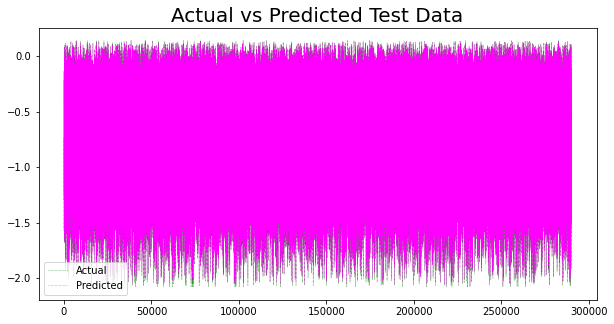

In [105]:
#Ploting graph for Actual vs Predicted data
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='green', linewidth=0.5, linestyle=':')
plt.plot(c, y_pred_lgbm_test, color='magenta', linewidth=0.5, linestyle=':')
plt.title('Actual vs Predicted Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

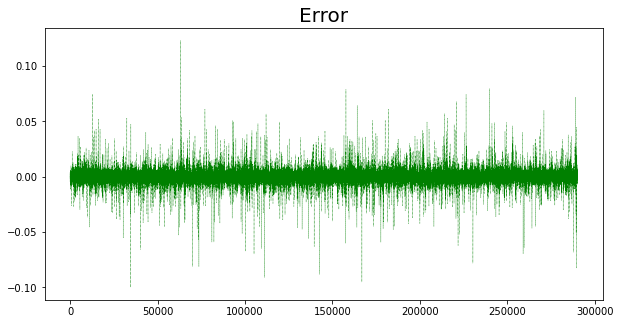

In [106]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_lgbm_test, color='green', linewidth=0.5, linestyle=':')
plt.title('Error', fontsize=20)
plt.show()

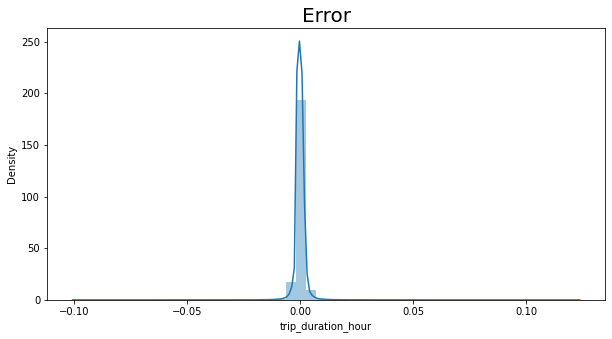

In [107]:
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_lgbm_test )
plt.title('Error', fontsize=20)
plt.show()

# Model Summary

Let's compare different parameters of all models.

In [108]:
models= ['Linear Regression', 'Lasso Regression','LightGBM Regressor','XGBoost Regressor']
train_mse= [lr_train_mse, lasso_train_mse, lgbm_train_mse, xgb_train_mse]
train_rmse= [lr_train_rmse, lasso_train_rmse, lgbm_train_rmse, xgb_train_rmse]
train_r2= [lr_train_r2, lasso_train_r2, lgbm_r2, xgb_train_r2]
train_adjusted_r2= [lr_train_r2_, lasso_train_r2_, lgbm_r2, xgb_train_r2_]

In [109]:
models= ['Linear Regression', 'Lasso Regression', 'LightGBM Regression','XGBoost Regressor']
test_mse= [lr_test_mse, lasso_test_mse, lgbm_test_mse, xgb_test_mse]
test_rmse= [lr_test_rmse, lasso_test_rmse, lgbm_test_rmse, xgb_test_rmse]
test_r2= [lr_test_r2, lasso_test_r2, lgbm_test_r2, xgb_test_r2]
test_adjusted_r2= [lr_test_r2_, lasso_test_r2_, lgbm_test_r2_, xgb_test_r2_]

In [110]:
Train_data_df=pd.DataFrame({'Model Name': models, 'Train MSE': train_mse, 'Train RMSE': train_rmse, 'Train R^2': train_r2, 
                            'Train Adjusted R^2': train_adjusted_r2})
Train_data_df

Model Name  Train MSE  Train RMSE  Train R^2  Train Adjusted R^2
0    Linear Regression   0.021158    0.145460   0.794578            0.794575
1     Lasso Regression   0.024105    0.155259   0.765969            0.765965
2  LightGBM Regression   0.000006    0.002464   0.999941            0.999941
3    XGBoost Regressor   0.000015    0.003920   0.999851            0.999851

In [111]:
Test_data_df= pd.DataFrame({'Model Name': models, 'Test MSE': test_mse, 'Test RMSE': test_rmse, 'Test R^2': test_r2, 
                            'Test Adjusted R^2': test_adjusted_r2})
Test_data_df

Model Name  Test MSE  Test RMSE  Test R^2  Test Adjusted R^2
0    Linear Regression  0.021348   0.146111  0.791650           0.791639
1     Lasso Regression  0.023966   0.154810  0.766102           0.766089
2  LightGBM Regression  0.000006   0.002504  0.999939           0.999939
3    XGBoost Regressor  0.000063   0.007912  0.999389           0.999389

# Conclusion



* We compared MSE, RMSE and R2 for all four regression models, to find which is the best model to predict the NYC taxi trip duration.   

* The Linear Regression and Lasso Regression didn't show any good prediction as compared to the other two. 
*   From above comparison table we can clearly see that XGBoost and LightGBM are the best models to predict trip duration of the NYC taxi. While LightGBM is fastest and more accurate than XGBoost. So, in between these two LightGBM is the best model. 

* R Square: R2 score represents the coefficient of how well the values fit compared to the original values. The value from 0 to 1 interpreted as percentages. The higher the value is, the better the model is.   
*   RMSE (Root Mean Squared Error): RMSE is the standard deviation of the residuals. Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it displays how concentrated the data is around the line of best fit. 


 

